## Team Members: 
- Gavin Robertson
- Aaron Ravela
- Nick Wilson

# Imports(start here)

In [1]:
!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
#Found on Kaggle
#https://www.kaggle.com/datasets/mohankrishnathalla/medical-insurance-cost-prediction

raw = pd.read_csv('https://raw.githubusercontent.com/Abled773/HI-Risk-Prediction-and-Analysis/main/medical_insurance.csv')

# Understanding the Data

In [3]:
# 54 Columns
raw.columns

Index(['person_id', 'age', 'sex', 'region', 'urban_rural', 'income',
       'education', 'marital_status', 'employment_status', 'household_size',
       'dependents', 'bmi', 'smoker', 'alcohol_freq', 'visits_last_year',
       'hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs',
       'medication_count', 'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c',
       'plan_type', 'network_tier', 'deductible', 'copay', 'policy_term_years',
       'policy_changes_last_2yrs', 'provider_quality', 'risk_score',
       'annual_medical_cost', 'annual_premium', 'monthly_premium',
       'claims_count', 'avg_claim_amount', 'total_claims_paid',
       'chronic_count', 'hypertension', 'diabetes', 'asthma', 'copd',
       'cardiovascular_disease', 'cancer_history', 'kidney_disease',
       'liver_disease', 'arthritis', 'mental_health', 'proc_imaging_count',
       'proc_surgery_count', 'proc_physio_count', 'proc_consult_count',
       'proc_lab_count', 'is_high_risk', 'had_major_procedure'],
      

In [4]:
raw.shape

(100000, 54)

In [5]:
raw.head()

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,...,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,...,0,1,0,2,0,1,1,0,1,0


In [6]:
# Data dTypes are well defined and only have 10 object Dtypes
# Some of the objects can be converted to categorical later on for consistency

raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   person_id                    100000 non-null  int64  
 1   age                          100000 non-null  int64  
 2   sex                          100000 non-null  object 
 3   region                       100000 non-null  object 
 4   urban_rural                  100000 non-null  object 
 5   income                       100000 non-null  float64
 6   education                    100000 non-null  object 
 7   marital_status               100000 non-null  object 
 8   employment_status            100000 non-null  object 
 9   household_size               100000 non-null  int64  
 10  dependents                   100000 non-null  int64  
 11  bmi                          100000 non-null  float64
 12  smoker                       100000 non-null  object 
 13  

In [7]:
raw.describe(include="all")

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
count,100000.000000,100000.000000,100000,100000,100000,1.000000e+05,100000,100000,100000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
unique,NaN,NaN,3,5,3,NaN,6,4,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Female,South,Urban,NaN,Bachelors,Married,Employed,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,49193,28029,60019,NaN,27996,53252,55269,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,50000.500000,47.521500,NaN,NaN,NaN,4.987390e+04,NaN,NaN,NaN,2.430900,...,0.014770,0.108310,0.130140,0.508530,0.158690,0.508390,0.50933,0.509140,0.367810,0.169700
std,28867.657797,15.988752,NaN,NaN,NaN,4.680021e+04,NaN,NaN,NaN,1.075126,...,0.120632,0.310773,0.336459,0.749755,0.463562,0.747218,0.75363,0.750455,0.482212,0.375371
min,1.000000,0.000000,NaN,NaN,NaN,1.100000e+03,NaN,NaN,NaN,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,25000.750000,37.000000,NaN,NaN,NaN,2.110000e+04,NaN,NaN,NaN,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,50000.500000,48.000000,NaN,NaN,NaN,3.620000e+04,NaN,NaN,NaN,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,75000.250000,58.000000,NaN,NaN,NaN,6.220000e+04,NaN,NaN,NaN,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000


In [8]:
# This is a strong dataset with no null values in all of the columns besides alcohol_freq
raw.isna().sum()


person_id                      0
age                            0
sex                            0
region                         0
urban_rural                    0
income                         0
education                      0
marital_status                 0
employment_status              0
household_size                 0
dependents                     0
bmi                            0
smoker                         0
alcohol_freq                   0
visits_last_year               0
hospitalizations_last_3yrs     0
days_hospitalized_last_3yrs    0
medication_count               0
systolic_bp                    0
diastolic_bp                   0
ldl                            0
hba1c                          0
plan_type                      0
network_tier                   0
deductible                     0
copay                          0
policy_term_years              0
policy_changes_last_2yrs       0
provider_quality               0
risk_score                     0
annual_med

In [9]:
# No Duplicate Rows
raw.duplicated().sum()

0

## Summary of structure analysis
From the Structure analysis, we can see the data:

 * Has a size of 5400000(100000 x 54)
 * Has well defined data types (13 floats, 31 ints, 10 objects)
 * All columns do not have null values and exist in all rows except for alchohol frequency
 * No duplicate rows








---



# Data Cleaning

Because this data is so well-defined, it needs very little cleaning in order to be operational. Still there are some tasks that we can do:

 * Remove unnecessary data for Risk analysis
 * Manage missing alchohol frequency data
 * Change some object data types to categorical
 * Create a table suitable for correlation analysis
 * Create a table suitable for regression

## Changing Object Data Types

In [10]:
# show all object dType columns and put them in a list
obj_cols = list(raw.select_dtypes(include='object').columns)
obj_cols

['sex',
 'region',
 'urban_rural',
 'education',
 'marital_status',
 'employment_status',
 'smoker',
 'alcohol_freq',
 'plan_type',
 'network_tier']

In [11]:
#see the range of data of object data types
for col in obj_cols:
    print(f"Unique values for column '{col}': {raw[col].unique()}")

Unique values for column 'sex': ['Female' 'Male' 'Other']
Unique values for column 'region': ['North' 'Central' 'West' 'South' 'East']
Unique values for column 'urban_rural': ['Suburban' 'Urban' 'Rural']
Unique values for column 'education': ['Doctorate' 'No HS' 'HS' 'Some College' 'Masters' 'Bachelors']
Unique values for column 'marital_status': ['Married' 'Single' 'Divorced' 'Widowed']
Unique values for column 'employment_status': ['Retired' 'Employed' 'Self-employed' 'Unemployed']
Unique values for column 'smoker': ['Never' 'Current' 'Former']
Unique values for column 'alcohol_freq': ['None' 'Weekly' 'Daily' 'Occasional']
Unique values for column 'plan_type': ['PPO' 'POS' 'HMO' 'EPO']
Unique values for column 'network_tier': ['Bronze' 'Gold' 'Platinum' 'Silver']


### Manage Missing Alcohol Frequency Data

Before we can deal with Alchohol frequency as a data type, we must manage the null values in this column. So let us look at the reasoning for these null values.

In [12]:
raw["alcohol_freq"].head(10)

0          None
1        Weekly
2          None
3          None
4         Daily
5         Daily
6    Occasional
7        Weekly
8          None
9        Weekly
Name: alcohol_freq, dtype: object

We can see that in the first 10 rows. There is no row that has a defined none category. Due to this, we can assume that null values mean that the patient does not consume alcohol.

For now we will leave it be and handle it when converting all object data types.

Now that we understand the object data, it's time to convert the data for correlation and regression analysis. Note that some columns will be modified once we get to modeling risk_score. This is because some of the columns that have no numerical data and no rankings cannot be correlated properly without one-hotting everything.

## Creating an Optimized Readable Data Table

In [13]:
# Copied raw table so we can create a clean table without affecting the original
data = raw.copy()

# Creating a clean READABLE table

# handle na alcohol values
data["alcohol_freq"] = data["alcohol_freq"].fillna("None")

# convert to category data types
data[obj_cols] = data[obj_cols].astype('category')

data['alcohol_freq'].value_counts()
data[obj_cols].info(0)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   sex                100000 non-null  category
 1   region             100000 non-null  category
 2   urban_rural        100000 non-null  category
 3   education          100000 non-null  category
 4   marital_status     100000 non-null  category
 5   employment_status  100000 non-null  category
 6   smoker             100000 non-null  category
 7   alcohol_freq       100000 non-null  category
 8   plan_type          100000 non-null  category
 9   network_tier       100000 non-null  category
dtypes: category(10)
memory usage: 978.5 KB


## Creating a Analysis-Ready Table

In [80]:
# one-hot all nominal values

# Create a copy of clean data, so we can create the analysis table safely.
transfer = data.copy()


nominal_cols = ["region","marital_status","employment_status","sex", "plan_type", "urban_rural"]
one_hot_nom = pd.get_dummies(transfer[nominal_cols], drop_first=True)

analysis_data = pd.concat([transfer.drop(nominal_cols, axis=1), one_hot_nom], axis=1)

analysis_data.head()

,person_id,age,income,education,household_size,dependents,bmi,smoker,alcohol_freq,visits_last_year,...,employment_status_Retired,employment_status_Self-employed,employment_status_Unemployed,sex_Male,sex_Other,plan_type_HMO,plan_type_POS,plan_type_PPO,urban_rural_Suburban,urban_rural_Urban
0,75722,52,22700.0,Doctorate,3,1,27.4,Never,None,2,...,1,0,0,0,0,0,0,1,1,0
1,80185,79,12800.0,No HS,3,1,26.6,Never,Weekly,2,...,0,0,0,0,0,0,1,0,0,1
2,19865,68,40700.0,HS,5,3,31.5,Never,None,1,...,1,0,0,1,0,1,0,0,0,0
3,76700,15,15600.0,Some College,5,3,31.6,Never,None,0,...,0,1,0,1,0,1,0,0,1,0
4,92992,53,89600.0,Doctorate,2,0,30.5,Never,Daily,3,...,0,1,0,1,0,0,1,0,1,0


In [81]:
# Create Ordinal Map
ordinal_maps = {
    'smoker': {'Never' : 0, 'Former' : 1, 'Current' : 2},
    'alcohol_freq': {"None" : 0, 'Occasional' : 1, 'Weekly' : 2, 'Daily' : 3},
    'education': {'No HS' : 0, 'HS' : 1, 'Some College' : 2, 'Bachelors' : 3, 'Masters' : 4, 'Doctorate' : 5},
    'network_tier': {'Bronze' : 0, 'Silver' : 1, 'Gold' : 2, 'Platinum' : 3},
}

for col, mapping in ordinal_maps.items():
    analysis_data[col] = analysis_data[col].map(mapping).astype(int)


analysis_data[list(ordinal_maps.keys())].head(10)
analysis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 65 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   person_id                        100000 non-null  int64  
 1   age                              100000 non-null  int64  
 2   income                           100000 non-null  float64
 3   education                        100000 non-null  int64  
 4   household_size                   100000 non-null  int64  
 5   dependents                       100000 non-null  int64  
 6   bmi                              100000 non-null  float64
 7   smoker                           100000 non-null  int64  
 8   alcohol_freq                     100000 non-null  int64  
 9   visits_last_year                 100000 non-null  int64  
 10  hospitalizations_last_3yrs       100000 non-null  int64  
 11  days_hospitalized_last_3yrs      100000 non-null  int64  
 12  med

## Conclusion (**Important**)

We have now created many tables used for different purposes. All of the existing tables' purposes will be listed below.

* raw

  The original imported table - is not cleaned.

* data
  
  This is a cleaned version of raw. It has converted null values in alcohol frequency to a defined "none". Converts all object data types to the category type.

  For visualization, please use this table.

* analysis_data

  This table is derived from the cleaned version. It encodes all category types into numeric data types that is readable for correlation and linear regression. **Note**, that this table is hard to read and not meant for the reader.
  
  Use this table for correlation and regression.


  Here is how it is encoded:

  * **Ordinal**
    
    These columns have a definitive ranking, so we can numerically rank these for analysis. The columns that are determined to be ordinal is smoker, alcohol_freq, education, education, and network_tier.

    Here is how they are organized:

    **smoker:**
    
    'Never' : 0, 'Former' : 1, 'Current' : 2
    
    **alcohol_freq:**
    
    'None' : 0, 'Occasional' : 1, 'Weekly' : 2, 'Daily' : 3
    
    **'education':**
    
    'No HS' : 0, 'HS' : 1, 'Some College' : 2, 'Bachelors' : 3, 'Masters' : 4, 'Doctorate' : 5
    
    **'network_tier':**

    'Bronze' : 0, 'Silver' : 1, 'Gold' : 2, 'Platinum' : 3

   * **Nominal**
   
   Nominal value has no ranking amongst the categories, because of this, all nominal values are one-hot encoded. One-hot encoding creates a boolean column for each unique value. This of course create a ton of columns (71 to be exact). This makes the data very hard to read and performance intensive, but the computations can still be easily handled by modern cpu's.

   Here is the list of nominal values:
   
   "region",
   "marital_status",
   "employment_status",
   "sex",
   "plan_type",
   "urban_rural"





# Data Analysis(Correlation/Visualization)

In [99]:
# Remember this, as we will take a deeper look at risk_score_correlations again in the Data Analysis portion.
corr_matrix = analysis_data.corr(numeric_only=True)
risk_score_correlations = corr_matrix['risk_score']

# In short, we have created and then taken all of the columns risk_score correlation, and created a set that has all of the super weak correlation columns
# risk_score <= -0.1 (weak postive) risk_score >= -0.1 (weak negtive)
# weak_cols contains correalations(x) between [-0.1, 0.1]
weak_cols = risk_score_correlations[(risk_score_correlations <= 0.1) & (risk_score_correlations >= -0.1)]
len(weak_cols) # number of weak columns

33

- Age has the highest correlation with risk score
- Then number of chronic conditions,
- Then blood pressure. Apparently systolic is more important than diastolic

In [108]:
sorted_risk_score_correlations = risk_score_correlations[abs(risk_score_correlations) > 0.01].sort_values(key=abs, ascending=False)[2:]
sorted_risk_score_correlations

age                       0.720989
chronic_count             0.666014
systolic_bp               0.553843
diastolic_bp              0.379526
hypertension              0.346731
visits_last_year          0.313346
claims_count              0.311008
annual_medical_cost       0.305971
total_claims_paid         0.305782
monthly_premium           0.295860
annual_premium            0.295859
mental_health             0.285307
smoker                    0.267917
arthritis                 0.265102
medication_count          0.264541
diabetes                  0.233629
avg_claim_amount          0.199926
asthma                    0.193422
hba1c                     0.183235
cardiovascular_disease    0.177263
proc_surgery_count        0.170409
copd                      0.147499
cancer_history            0.118792
had_major_procedure       0.114677
proc_lab_count            0.110210
proc_imaging_count        0.109206
bmi                       0.108921
proc_consult_count        0.104791
proc_physio_count   

In [109]:
# There are no strong negative risk score correlations:
negative_risk_score_correlations = risk_score_correlations[risk_score_correlations < 0].sort_values(ascending=True)
negative_risk_score_correlations

Series([], Name: risk_score, dtype: float64)

In [110]:
corr_data = analysis_data.drop(columns=weak_cols.index)
corr_data.head()
corr_data.shape[1] # columns left:

32

## Risk

In [166]:
# is_high_risk just means risk_score > 0.6
high_risk_people = data[data['is_high_risk'] == True]
low_risk_people = data[data['is_high_risk'] == False]

[Text(0, 0, 'Low risk'), Text(1, 0, 'High risk')]

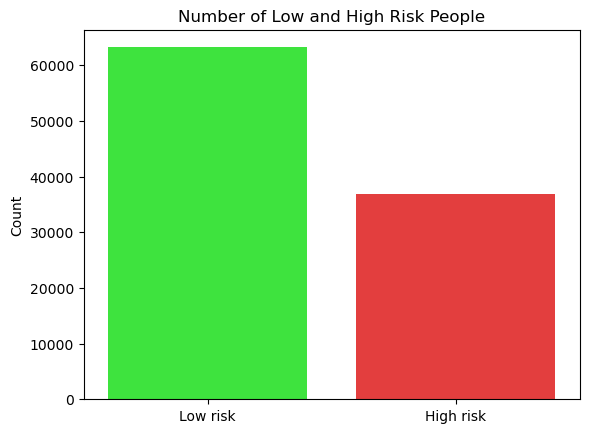

In [167]:
ax = sns.countplot(data=data, x='is_high_risk', palette=['#22ff22', '#ff2222'])
plt.ylabel('Count')
plt.xlabel(None)
plt.title('Number of Low and High Risk People')

ax.set_xticklabels(['Low risk', 'High risk'])

Text(0.5, 1.0, 'Distribution of Risk Scores')

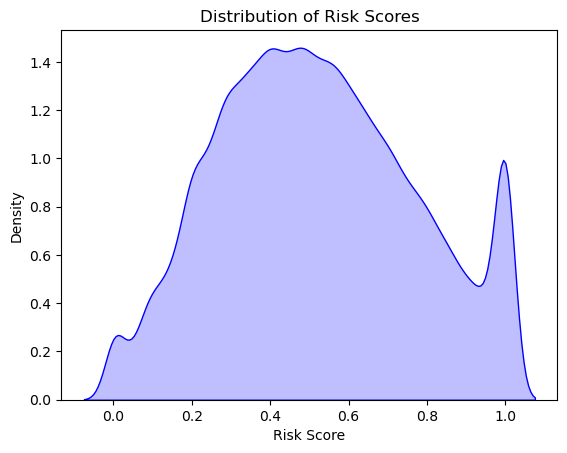

In [165]:
sns.kdeplot(data['risk_score'], fill=True, color='blue')
plt.xlabel('Risk Score')
plt.ylabel('Density')
plt.title('Distribution of Risk Scores')

## Age
Age has the highest correlation with risk score

<Axes: title={'center': 'Age distribution of dataset'}, ylabel='Frequency'>

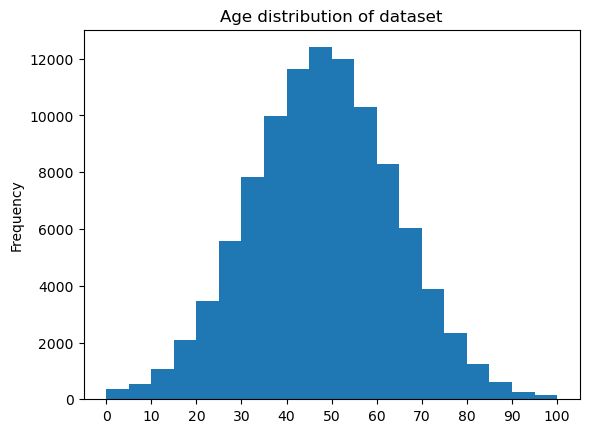

In [118]:
data['age'].plot.hist(bins=20, xticks=range(0, 110, 10), title="Age distribution of dataset")

In [119]:
average_age = data['age'].mean()
average_age

47.5215

In [121]:
# correlations with age
age_correlations = data.corr(numeric_only=True)['age']
irrelevant_age_cols = ['age', 'person_id', 'is_high_risk']
for col in irrelevant_age_cols:
    age_correlations.pop(col)
relevant_age_correlations = age_correlations[age_correlations > 0.1].sort_values(ascending=False)
relevant_age_correlations

risk_score             0.720989
systolic_bp            0.555174
diastolic_bp           0.304183
chronic_count          0.136148
annual_medical_cost    0.131166
annual_premium         0.127473
monthly_premium        0.127473
ldl                    0.110565
total_claims_paid      0.101717
Name: age, dtype: float64

Of the attributes we are looking at, blood pressure and number of chronic conditions are the main things that go up as you age that affect risk score

## Smoking

As seen in the graph below, current smokers have a much higher risk score on average than those who are not.
Surprisingly, former smokers have an almost identical risk score on average to those who never smoked

Text(0.5, 1.0, 'Risk Score by Smoking Status')

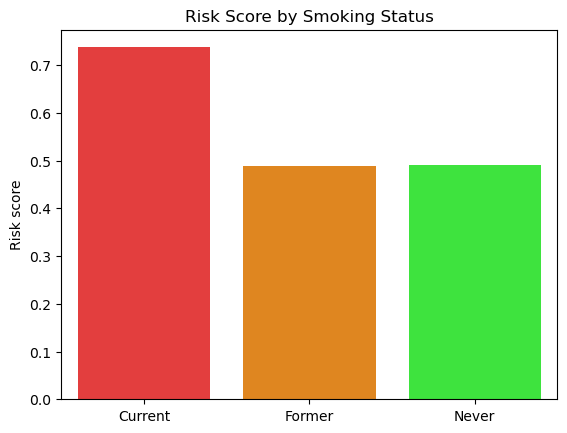

In [177]:
grouped = data.groupby('smoker')['risk_score'].mean().reset_index()

sns.barplot(data=grouped, x='smoker', y='risk_score', palette=['#ff2222', '#ff8800', '#22ff22'])

plt.ylabel("Risk score")
plt.xlabel(None)
plt.title("Risk Score by Smoking Status")

## Alcohol
Surprisingly, alcohol seems to have an incredibly small effect on the risk score

In [125]:
data['alcohol_freq'].value_counts()

Occasional    45078
None          30083
Weekly        19833
Daily          5006
Name: alcohol_freq, dtype: int64

Text(0.5, 1.0, 'Risk Score by Alcohol Consumption Frequency')

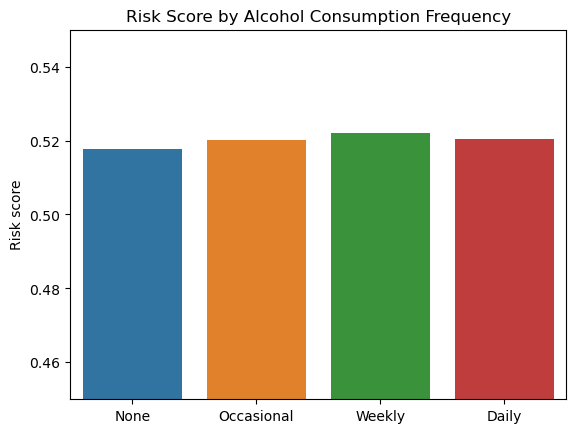

In [182]:
grouped = data.groupby('alcohol_freq')['risk_score'].mean().reset_index()

sns.barplot(data=grouped, x='alcohol_freq', y='risk_score', order=['None', 'Occasional', 'Weekly', 'Daily'])
plt.ylim(0.45 , 0.55)
plt.ylabel("Risk score")
plt.xlabel(None)
plt.title("Risk Score by Alcohol Consumption Frequency")

## Sex

Men and women have basically identical risk scores on average. 'Other' has a very slightly lower mean risk score, likely due to statistical variation from the small population size

Text(0, 0.5, 'Risk Score')

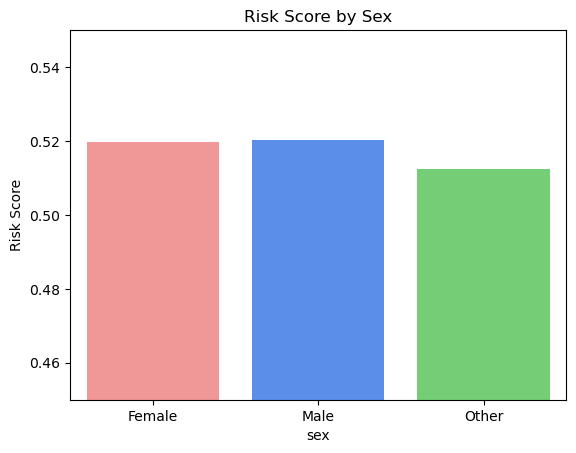

In [197]:
grouped = data.groupby('sex')['risk_score'].mean().reset_index()
sns.barplot(data=grouped, x='sex', y='risk_score', palette=['#ff8888', '#4488ff', '#66dd66'])
plt.ylim(0.45 , 0.55)
plt.title("Risk Score by Sex")
plt.ylabel("Risk Score")

# Correlation Heatmap

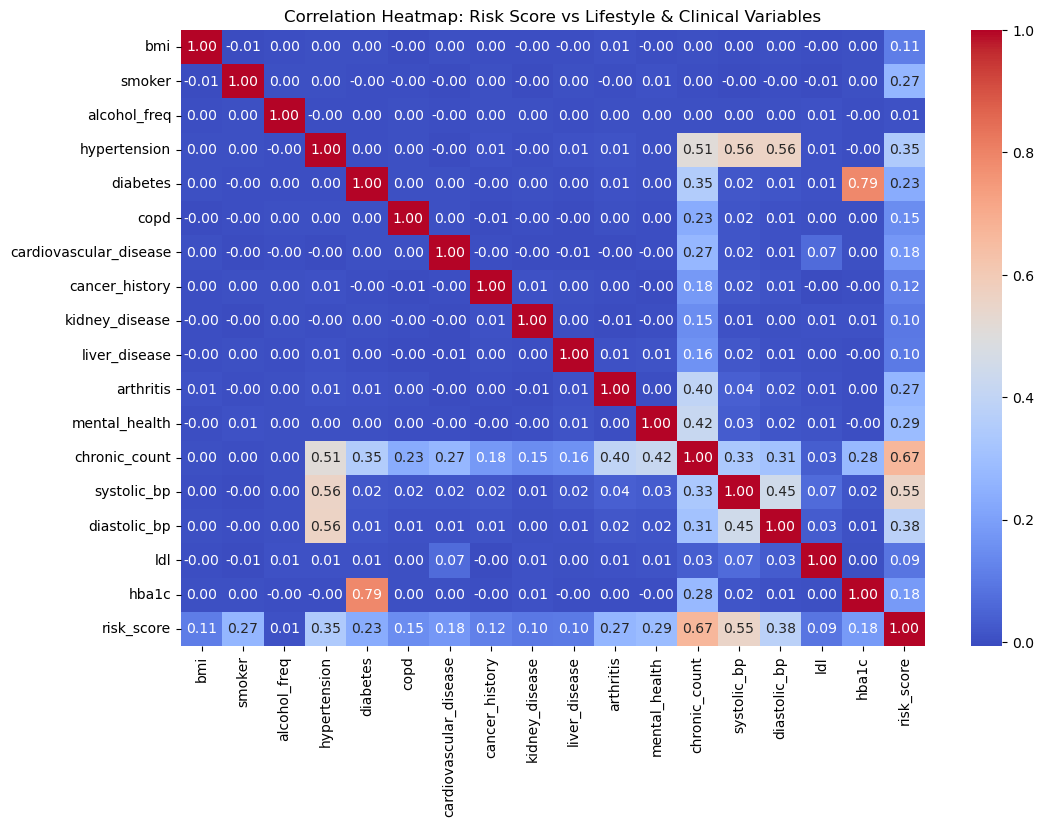

In [208]:
cols = [
    "bmi","smoker","alcohol_freq",
    "hypertension","diabetes","copd","cardiovascular_disease","cancer_history",
    "kidney_disease","liver_disease","arthritis","mental_health","chronic_count",
    "systolic_bp","diastolic_bp","ldl","hba1c","risk_score",
]

df_subset = analysis_data[cols]

# Keep only numeric columns for correlation
numeric_cols = df_subset.select_dtypes(include=["float64","int64"]).columns

corr = df_subset[numeric_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Risk Score vs Lifestyle & Clinical Variables")
plt.show()

# Correlation Bar Chart

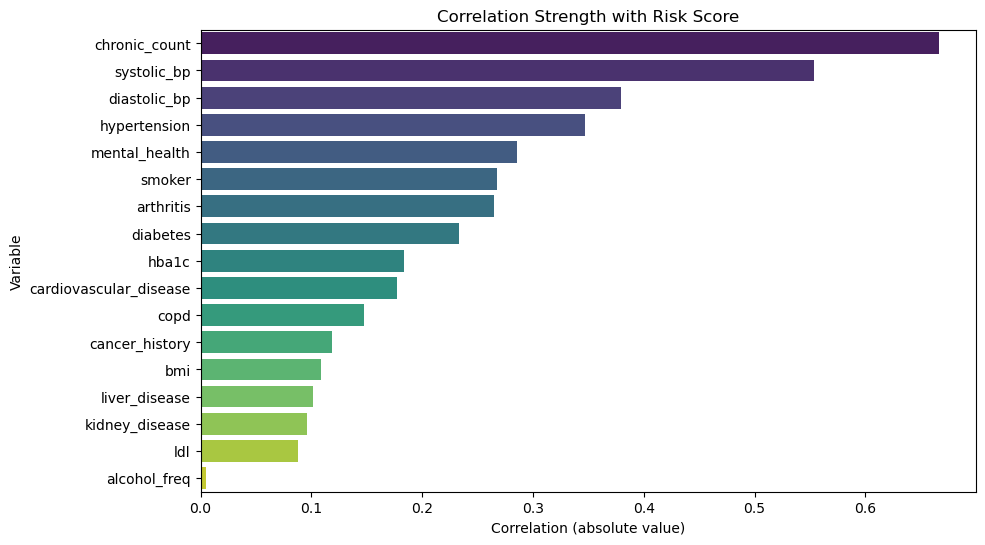

In [209]:
corrs = df_subset[numeric_cols].corr()["risk_score"].drop("risk_score")
corrs = corrs.abs().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=corrs.values, y=corrs.index, palette="viridis")
plt.title("Correlation Strength with Risk Score")
plt.xlabel("Correlation (absolute value)")
plt.ylabel("Variable")
plt.show()

# Linear Regression Model("HEAVILY IN PROGRESS")

In [31]:
test_data = analysis_data.drop(["risk_score", "is_high_risk"], axis=1)

#default split
data_train, data_test, risk_train, risk_test = train_test_split(test_data, analysis_data['risk_score'], random_state=42)

In [32]:
#default Linear Regression model with all encodings
defaultModel = LinearRegression()
defaultModel.fit(data_train, risk_train)
def_risk_pred = defaultModel.predict(data_test)

In [33]:
defaultModel.score(data_test, risk_test)

0.9357014024632645

## Testing the Model's Error.

In [34]:
print("R² on test set:", r2_score(risk_test, def_risk_pred))

R² on test set: 0.9357014024632645


In [35]:
#mean squared error
mse = mean_squared_error(risk_test, def_risk_pred)
print("MSE on test set:", mse)

#root mean squared error
print("RMSE on test set:", np.sqrt(mse))

#mean absolute error
mae = mean_absolute_error(risk_test, def_risk_pred)
print("MAE on test set:", mae)


MSE on test set: 0.004052145523595092
RMSE on test set: 0.0636564649002369
MAE on test set: 0.047710353894953726


In [36]:
residual = risk_test - def_risk_pred
sse = np.sum(residual**2)
rows, cols = analysis_data.shape
aic = rows * np.log(sse/rows) + 2*(cols + 1)

print("The AIC is: ", aic)

The AIC is:  -689348.3140343926


## Optimizing our Model

In [37]:
numeric = list(test_data.select_dtypes(include=['int64','float64']).columns)

scaler=StandardScaler()
data_train[numeric] = scaler.fit_transform(data_train[numeric])
data_test[numeric] = scaler.transform(data_test[numeric])

In [38]:
linearModel = LinearRegression()
linearModel.fit(data_train, risk_train)
risk_pred = linearModel.predict(data_test)
linearModel.score(data_test, risk_test)

0.9357014809369875

## Inspecting the Model's Coefficients and Intercept

In [39]:
intercept = linearModel.intercept_
print("Intercept:", intercept)
print("Coefficients:", linearModel.coef_)


Intercept: -744922265.6206586
Coefficients: [ 3.69808262e-04  1.61053564e-01  5.37932332e-05 -1.49920127e-04
 -1.50104168e+09  1.32850912e+09  2.66335217e-02  9.77424707e-02
 -5.52387365e-04  9.69531556e-04  7.45592119e-04 -4.05497434e-03
 -3.23866863e-04  3.76398651e-04  5.16807994e-04 -3.41644376e-04
 -4.93404088e-04  5.14237187e-04  3.31848552e-04  4.07582933e-04
 -2.98979651e-04 -1.84995952e-04 -2.80715450e-04  5.09568282e-03
 -2.06747462e+00  2.06431470e+00  4.57166563e-04  4.52075211e-03
 -5.97990508e-03  3.41642391e+08 -1.70493665e+08 -1.18964951e+08
 -9.99669721e+07 -7.88102873e+07 -9.34754319e+07 -6.13405726e+07
 -5.10939477e+07 -5.06128568e+07 -1.31532923e+08 -1.42581647e+08
 -8.81850719e-05 -5.46473265e-03  4.38004732e-04 -3.44932079e-04
  2.36511230e-04  6.61480427e-03  4.99188900e-05 -5.01632690e-04
 -8.38041306e-05  4.28557396e-04  1.39851235e+09 -6.31421804e-04
 -7.44193792e-04  1.00088865e-03  6.25371933e-04  1.30173564e-03
  7.51145184e-04 -7.82132149e-04  1.20651722e-

In [40]:
# Assuming your features are in a DataFrame called X_train or analysis_data
feature_names = data_train.columns  # or whatever table you trained on

# Create coef_table
coef_table = pd.Series(linearModel.coef_, index=feature_names)

# Sort features by absolute value of coefficient
sorted_features = sorted(coef_table.items(), key=lambda x: abs(x[1]), reverse=True)
for feature, coef in sorted_features:
    print(f"{feature}: {coef}")

household_size: -1501041675.7357833
marital_status_Married: 1398512352.1835182
dependents: 1328509122.1014528
chronic_count: 341642390.5332367
hypertension: -170493664.82399368
mental_health: -142581646.7144758
arthritis: -131532923.19091286
diabetes: -118964951.07155016
asthma: -99966972.07651144
cardiovascular_disease: -93475431.93709134
copd: -78810287.30211866
cancer_history: -61340572.622980386
kidney_disease: -51093947.679219216
liver_disease: -50612856.799722224
annual_premium: -2.06747462066807
monthly_premium: 2.064314699308151
age: 0.16105356374592494
smoker: 0.09774247068135994
bmi: 0.026633521732367417
had_major_procedure: 0.006614804267883301
total_claims_paid: -0.005979905079297576
proc_surgery_count: -0.005464732646942139
annual_medical_cost: 0.005095682816025446
avg_claim_amount: 0.004520752107145611
days_hospitalized_last_3yrs: -0.004054974340135964
employment_status_Unemployed: 0.0013017356395721436
plan_type_HMO: 0.001206517219543457
employment_status_Retired: 0.0010

## Test

In [41]:
test_data = data.drop(["risk_score", "is_high_risk"], axis=1)
data_train, data_test, risk_train, risk_test = train_test_split(test_data, data['risk_score'], random_state=42)
model = CatBoostRegressor(verbose=0)

model.fit(data_train, risk_train, cat_features=obj_cols)


catboost_score = model.score(data_test, risk_test)
catboost_score

0.9999233717701832

In [42]:
risk_pred = model.predict(data_test)

In [43]:
print("R² on test set:", r2_score(risk_test, risk_pred))

#mean squared error
mse = mean_squared_error(risk_test, risk_pred)
print("MSE on test set:", mse)

#root mean squared error
print("RMSE on test set:", np.sqrt(mse))

#mean absolute error
mae = mean_absolute_error(risk_test, risk_pred)
print("MAE on test set:", mae)

R² on test set: 0.9999233717701832
MSE on test set: 4.829168136297399e-06
RMSE on test set: 0.0021975368338886607
MAE on test set: 0.0010106774206619597


In [45]:
feature_importances = model.get_feature_importance()
feature_names = data.columns  # Your feature DataFrame

# Combine into a table
importance_table = dict(zip(feature_names, feature_importances))

# Sort by importance
sorted_importance = sorted(importance_table.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.5f}")

total_claims_paid: 38.93976
age: 37.58839
smoker: 19.50100
bmi: 3.96617
network_tier: 0.00059
marital_status: 0.00044
urban_rural: 0.00044
visits_last_year: 0.00026
plan_type: 0.00022
proc_imaging_count: 0.00019
region: 0.00019
sex: 0.00017
avg_claim_amount: 0.00015
income: 0.00015
employment_status: 0.00015
hba1c: 0.00014
systolic_bp: 0.00013
person_id: 0.00013
provider_quality: 0.00011
diastolic_bp: 0.00010
proc_consult_count: 0.00010
dependents: 0.00009
monthly_premium: 0.00007
mental_health: 0.00007
ldl: 0.00007
risk_score: 0.00007
household_size: 0.00005
proc_surgery_count: 0.00005
medication_count: 0.00005
claims_count: 0.00005
deductible: 0.00005
proc_physio_count: 0.00005
policy_term_years: 0.00004
education: 0.00004
annual_premium: 0.00004
alcohol_freq: 0.00004
annual_medical_cost: 0.00004
copay: 0.00003
kidney_disease: 0.00002
diabetes: 0.00002
copd: 0.00001
cancer_history: 0.00001
chronic_count: 0.00001
liver_disease: 0.00001
days_hospitalized_last_3yrs: 0.00001
asthma: 0.00

### Score with only 4 columns with the highest feature importance

In [46]:
minimal_data = data[["total_claims_paid","age","smoker","bmi"]]

data_train, data_test, risk_train, risk_test = train_test_split(minimal_data, data['risk_score'], random_state=42)
model = CatBoostRegressor(verbose=0)
model.fit(data_train, risk_train, cat_features=["smoker"])

print(model.score(data_test, risk_test))

0.7129159924684699


## Linear Regression Model

R² on test set: 0.6997711906349038


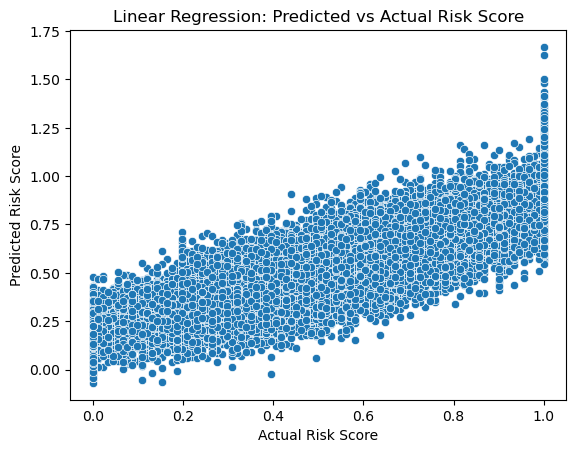

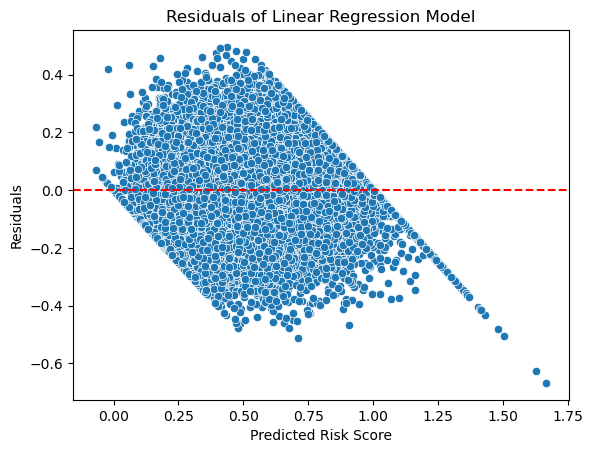

In [50]:
# Select predictors and target
predictors = [
    "bmi","smoker","alcohol_freq",
    "hypertension","diabetes","copd","cardiovascular_disease","cancer_history",
    "kidney_disease","liver_disease","arthritis","mental_health","chronic_count",
    "systolic_bp","diastolic_bp","ldl","hba1c"
]
X = raw[predictors].copy()
y = raw["risk_score"]

# Encode categorical predictors safely
for col in ["smoker","alcohol_freq"]:
    X[col] = X[col].astype("category").cat.codes

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Validate with R²
print("R² on test set:", model.score(X_test, y_test))

# Predict
y_pred = model.predict(X_test)

# Plot predicted vs actual
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Risk Score")
plt.ylabel("Predicted Risk Score")
plt.title("Linear Regression: Predicted vs Actual Risk Score")
plt.show()

# Residual plot
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Risk Score")
plt.ylabel("Residuals")
plt.title("Residuals of Linear Regression Model")
plt.show()